![](https://raw.githubusercontent.com/fdannemanndugick/roses2021/main/header.png)

# ROSES 2021 - Seismo-acoustics - August 10th 2021

Jelle Assink<br/>
<br/>
**Royal Netherlands Meteorological Institute**<br/>
*R&D Seismology and Acoustics*<br/>
<br/>
e-mail: *jelle.assink@knmi.nl*

# Introduction

In this notebook, we'll do / learn the following:

1. Download infrasound data from an earthquake of interest
2. Review (1) station metadata and (2) sensor response
3. Perform a first analysis based on traveltime and spectral analysis
4. Learn about array responses
5. Beamform array and interpret results
6. Perform FK-domain analyses

Enjoy! :)

Before we continue, let's load these first

In [1]:
%config Completer.use_jedi = False
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, AutoLocator, FixedLocator
from matplotlib.ticker import ScalarFormatter, FuncFormatter
plt.rcParams['figure.dpi'] = 100

# Seismo-acoustic event analysis

### Get event metadata

In [3]:
from obspy.clients.fdsn import Client as fdsnClient
client = fdsnClient('USGS')

# M 6.2 - 5 km WNW of Accumoli, Italy (24 Aug. 2016)
catalog = client.get_events(eventid='us10006g7d')

# M 8.2 - 104 km SE of Perryville, Alaska (29 July 2021)
#catalog = client.get_events(eventid='us6000f02w')

#catalog.write('event.xml', format='QuakeML')
print(catalog)
event = catalog[0]
origin = event.preferred_origin()

# take these bounds to select from the inventory
event_day_t0 = origin.time.replace(hour=0, minute=0, second=0, microsecond=0)
event_day_t1 = event_day_t0 + 24*3600

1 Event(s) in Catalog:
2016-08-24T01:36:32.870000Z | +42.723,  +13.188 | 6.2 Mww | manual


/home/kdavidson/anaconda3/envs/roses/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


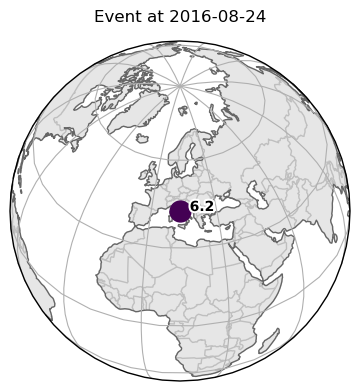

In [4]:
catalog.plot(projection='ortho')
plt.show()

### Load Obspy array processing functions

In [5]:
from obspy.core.util import AttribDict
from obspy.signal.array_analysis import array_processing
from obspy.geodetics.base import gps2dist_azimuth
from obspy import UTCDateTime, read, read_inventory

### Some ObsPy wrapper functions

In [6]:
from array_processing import get_data, stream2sds
from metadata import get_metadata

### Configure array parameters

The following fields determine the parameters of the station for which we are going to download metadata and waveform data. These parameters will select data of the infrasound array near Freyung Germany, station I26DE. This station is co-located with seismic array GERESS.

This station is also part of the <a href='https://www.ctbto.org/map/'>verification network</a> for the Comprehensive Nuclear-Test-Ban Treaty (CTBT). Not all arrays are publicly available, although data can be requested through the CTBT Organisation for research purpoes. More publicly available IMS infrasound arrays can be found through the map webservice of <a href='http://ds.iris.edu/gmap/#network=IM&channel=*DF&planet=earth'>IRIS</a>.

There are also many other non-IMS infrasound stations and arrays, as can be seen on the following <a href='http://ds.iris.edu/gmap/#channel=*DF&network=*&planet=earth'>map</a>.


In [7]:
network = 'GR'
array = 'I26DE'
channel = 'BDF'
station = 'I26*'
location = '*'

Typically when processing data, it is useful to first download the necessary datafiles and store them locally in your working directory. If you want to re-process the data, you don't have to go through the download process again.

This is the procedure that we are going to follow here:

1. First download the station metadata, also called 'inventory'. This inventory is stored as a StationXML file. We are going to analyze this inventory because it will tell us about the station characteristics.

2. Using the inventory, we are going to download the waveform data into an ObsPy Stream. This stream is then written to a local mseed volume, which can be easily queried using ObsPy built-in functions.

After the 'getting' part is done, we will proceed with the 'processing'.

_______________

The following variables determine the names of the FDSN webservices and the local directories that we are going to use.

In [8]:
fid_inv = '{}.{}.xml'.format(network,array)
fid_mseed = '{}.{}.mseed'.format(network,array)
sds_root = 'data'

routing_type = 'iris-federator'
#routing_type = 'eida-routing'
metadata_source_remote = dict(fdsn=routing_type)
waveform_source_remote = dict(fdsn=routing_type)

metadata_source_local = dict(local=fid_inv)
waveform_source_local = dict(local=sds_root)

## Get data

### 1. Metadata

In [9]:
inv = get_metadata(metadata_source_remote, network=network, station=station,
                   location=location, channel=channel, starttime=event_day_t0, endtime=event_day_t1)

print(inv)
inv.write(fid_inv, 'STATIONXML')

Inventory created at 2021-08-29T10:41:13.781171Z
	Created by: ObsPy 1.2.2
		    https://www.obspy.org
	Sending institution: ObsPy FDSN Routing 1.2.2,SeisComP (BGR)
	Contains:
		Networks (1):
			GR
		Stations (8):
			GR.I26H1 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H2 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H3 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H4 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H5 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H6 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H7 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H8 (BGR Station Infrasound Array CTBTO IS26, Germany)
		Channels (8):
			GR.I26H1..BDF, GR.I26H2..BDF, GR.I26H3..BDF, GR.I26H4..BDF, 
			GR.I26H5..BDF, GR.I26H6..BDF, GR.I26H7..BDF, GR.I26H8..BDF


#### Compute distance, azimuth and back azimuth

Computes the distance between two geographic points on the WGS84 ellipsoid and the forward and backward azimuths between these points. This function will check if you have installed the Python module <a href='http://geographiclib.sf.net'>geographiclib</a> - a very fast module for converting between geographic, UTM, UPS, MGRS, and geocentric coordinates, for geoid calculations, and for solving geodesic problems.

Otherwise ObsPy's implemented Vincenty's Inverse formula is used which has known limitations for two nearly antipodal points and is ca. 4x slower.

In [10]:
rcv = inv[0][0][0]
(dist_m, azi, bazi) = gps2dist_azimuth(origin.latitude, origin.longitude, rcv.latitude, rcv.longitude)
dist_km = dist_m / 1e3

print(f'Source-receiver distance {dist_km:.2f} km')
print(f'Source-receiver azimuth {azi:.2f} degrees')
print(f'Source-receiver back-azimuth {bazi:.2f} degrees')

Source-receiver distance 681.81 km
Source-receiver azimuth 3.28 degrees
Source-receiver back-azimuth 183.66 degrees


### 2. Waveform data

First determine the timespan of interest. Here we'll define the starttime as a minute prior to the origin time as starttime and the endtime as the origin time plus the time it would take for a wave with a speed of 0.15 km/s to reach the station. We call this speed of 0.15 km/s a **celerity**.

Infrasonic waves typically propagate through the atmopshere with celerities between 210 m/s and 360 m/s.
However, we will see that the celerities may be higher than this range. 

In [11]:
celerity_min = 0.15
t0 = origin.time - 60
t1 = origin.time + dist_km / celerity_min

t0 = t0.replace(second=0, microsecond=0)
t1 = t1.replace(second=0, microsecond=0)
print(t0,t1)

2016-08-24T01:35:00.000000Z 2016-08-24T02:52:00.000000Z


In [12]:
margin = 10
sample_rate = 1.0/inv[0][0][0].sample_rate
st = get_data(waveform_source_remote, inventory=inv, starttime=t0-margin, endtime=t1-sample_rate+margin)
st.trim(t0,t1)
#st.write(fid_mseed, 'mseed')
print(st)

8 Trace(s) in Stream:
GR.I26H1..BDF | 2016-08-24T01:35:00.000000Z - 2016-08-24T02:52:00.000000Z | 20.0 Hz, 92401 samples
GR.I26H2..BDF | 2016-08-24T01:35:00.000000Z - 2016-08-24T02:52:00.000000Z | 20.0 Hz, 92401 samples
GR.I26H3..BDF | 2016-08-24T01:35:00.000000Z - 2016-08-24T02:52:00.000000Z | 20.0 Hz, 92401 samples
GR.I26H4..BDF | 2016-08-24T01:35:00.000000Z - 2016-08-24T02:52:00.000000Z | 20.0 Hz, 92401 samples
GR.I26H5..BDF | 2016-08-24T01:35:00.000000Z - 2016-08-24T02:52:00.000000Z | 20.0 Hz, 92401 samples
GR.I26H6..BDF | 2016-08-24T01:35:00.000000Z - 2016-08-24T02:52:00.000000Z | 20.0 Hz, 92401 samples
GR.I26H7..BDF | 2016-08-24T01:35:00.000000Z - 2016-08-24T02:52:00.000000Z | 20.0 Hz, 92401 samples
GR.I26H8..BDF | 2016-08-24T01:35:00.000000Z - 2016-08-24T02:52:00.000000Z | 20.0 Hz, 92401 samples


In [13]:
stream2sds(st, path_root=sds_root)

Writing mseed file [ data/2016/GR/I26H1/BDF.D/GR.I26H1..BDF.D.2016.237 ] -> OK!
Writing mseed file [ data/2016/GR/I26H2/BDF.D/GR.I26H2..BDF.D.2016.237 ] -> OK!
Writing mseed file [ data/2016/GR/I26H3/BDF.D/GR.I26H3..BDF.D.2016.237 ] -> OK!
Writing mseed file [ data/2016/GR/I26H4/BDF.D/GR.I26H4..BDF.D.2016.237 ] -> OK!
Writing mseed file [ data/2016/GR/I26H5/BDF.D/GR.I26H5..BDF.D.2016.237 ] -> OK!
Writing mseed file [ data/2016/GR/I26H6/BDF.D/GR.I26H6..BDF.D.2016.237 ] -> OK!
Writing mseed file [ data/2016/GR/I26H7/BDF.D/GR.I26H7..BDF.D.2016.237 ] -> OK!
Writing mseed file [ data/2016/GR/I26H8/BDF.D/GR.I26H8..BDF.D.2016.237 ] -> OK!


## Processing data

### 1. Metadata

In [14]:
inv = read_inventory(fid_inv)

/home/kdavidson/anaconda3/envs/roses/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


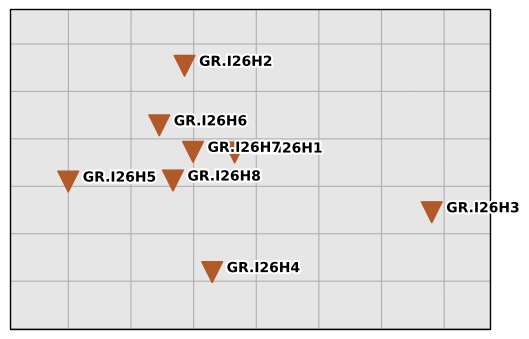

In [15]:
fig = inv.plot(projection='local')

Channel Response
	From PA (None) to COUNTS (None)
	Overall Sensitivity: 6980.8 defined at 1.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 6980.8
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 1


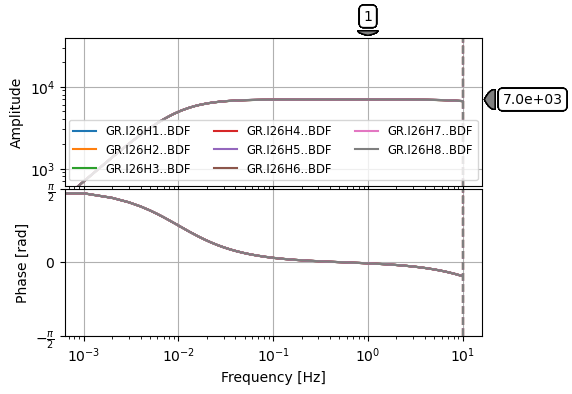

In [16]:
ref_ele = inv.get_contents()['channels'][0]
resp = inv.get_response(ref_ele, event_day_t0)
print(resp)
fig = inv.plot_response(1e-3)

In [17]:
rcv = inv[0][0][0]
(dist_m, azi, bazi) = gps2dist_azimuth(origin.latitude, origin.longitude, rcv.latitude, rcv.longitude)
dist_km = dist_m / 1e3

print(f'Source-receiver distance {dist_km:.2f} km')
print(f'Source-receiver azimuth {azi:.2f} degrees')
print(f'Source-receiver back-azimuth {bazi:.2f} degrees')

Source-receiver distance 681.81 km
Source-receiver azimuth 3.28 degrees
Source-receiver back-azimuth 183.66 degrees


In [18]:
t0 = origin.time - 60
t1 = origin.time + dist_km / celerity_min

t0 = t0.replace(second=0, microsecond=0)
t1 = t1.replace(second=0, microsecond=0)
print(t0,t1)

2016-08-24T01:35:00.000000Z 2016-08-24T02:52:00.000000Z


### 2. Waveform data

In [19]:
st = get_data(waveform_source_local, inventory=inv, starttime=t0, endtime=t1)
#st = read(fid_mseed)
#st.trim(t0, t1)

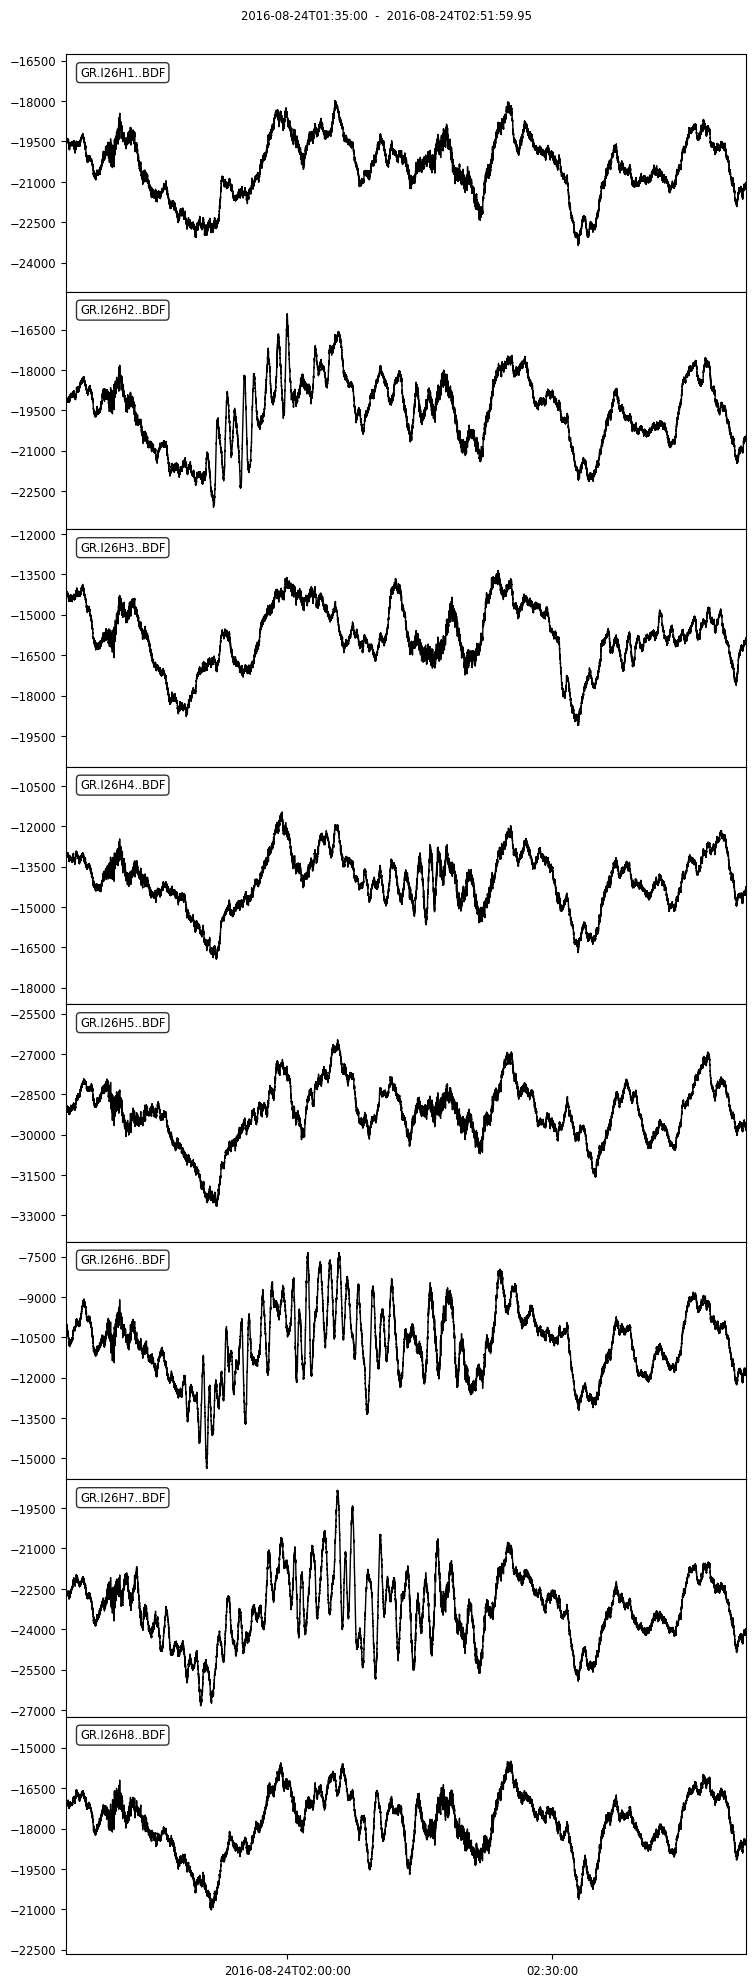

In [20]:
fig = st.plot()

#### Deconvolve instrument response (to go from "counts" to "pascals")

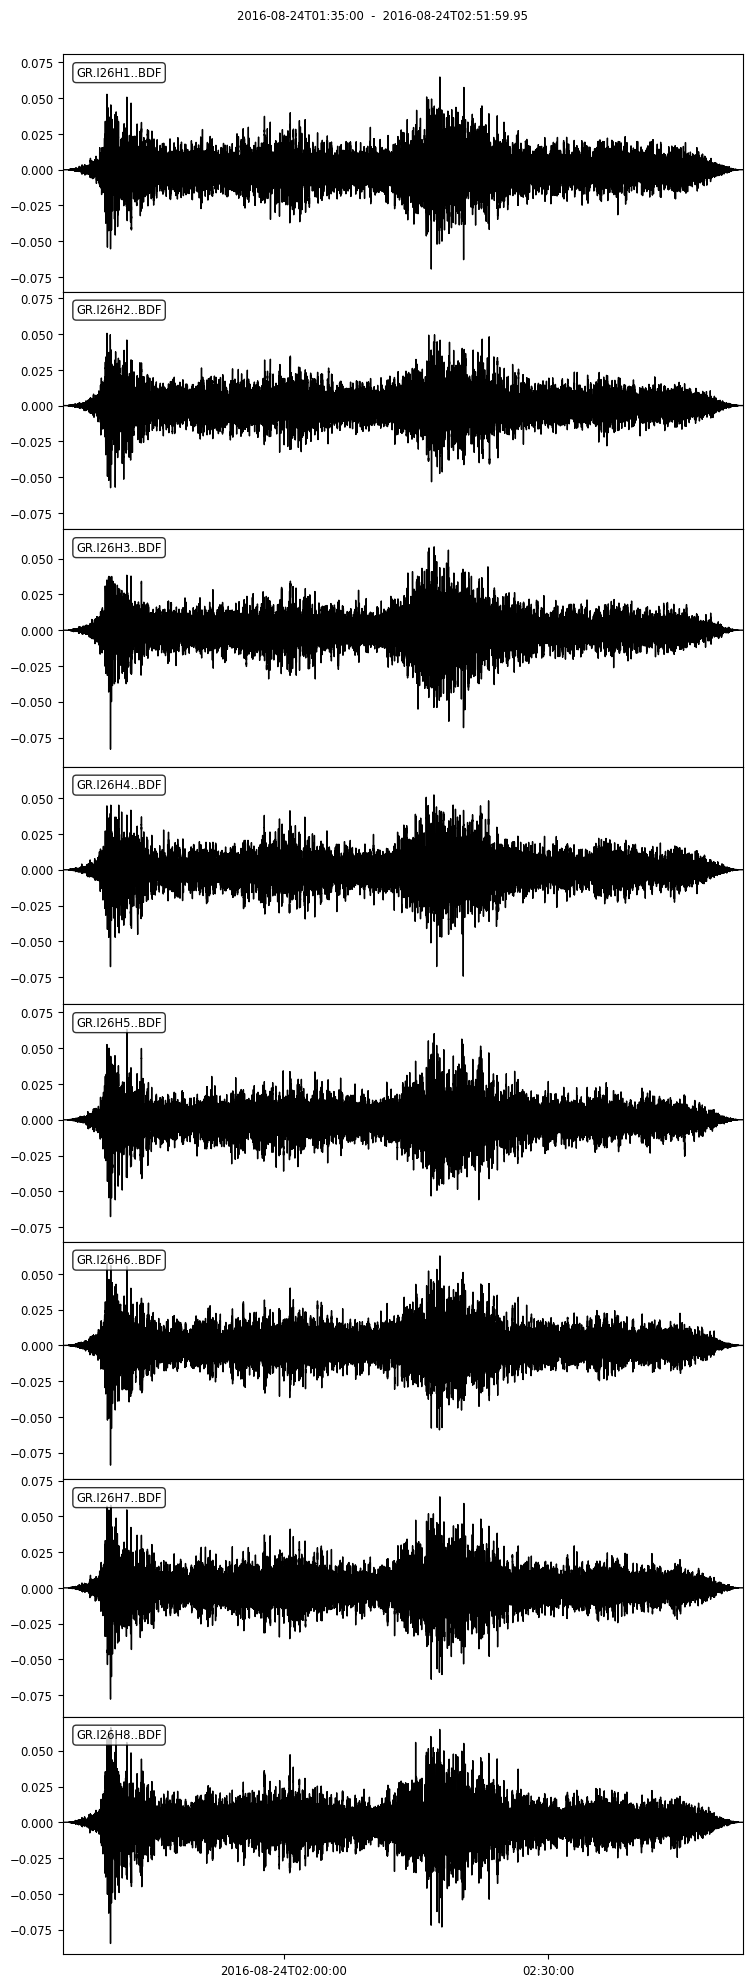

In [21]:
f_min = 0.1
f_max = 9.0

pre_filt = [0.9*f_min, f_min, f_max, 1.1*f_max]
st.remove_response(inventory=inv, pre_filt=pre_filt)

st.taper(0.1)
st.trim(t0, t1)

fig = st.plot()

#### Spectral analysis

In [22]:
tr = st[0]

print(tr)
w  = tr.data
Fs = tr.stats.sampling_rate
t_unix = tr.times('timestamp')
t_mpl = tr.times('matplotlib')

GR.I26H1..BDF | 2016-08-24T01:35:00.000000Z - 2016-08-24T02:51:59.950000Z | 20.0 Hz, 92400 samples


In [23]:
from scipy import signal
from datetime import timedelta

window_length = 30.0
segment_size = int(window_length*Fs)
oversampling = 4
overlap = 95.0
f_min = 1/window_length

(f, tf, Pxx) = signal.spectrogram(w, Fs,  
                                  window=('hanning'),
                                  nperseg=segment_size, 
                                  nfft=oversampling*segment_size, 
                                  noverlap=(overlap/100)*segment_size,
                                  scaling='density'
                                 )
tf_vec = [timedelta(seconds=t) + tr.stats.starttime.datetime for t in tf ]
tf_mpl = mdates.date2num(tf_vec)

# Select the frequencies of interest
idx = np.where((f>=f_min) & (f<=f_max))
Pxx = Pxx[idx]
f = f[idx]

# Convert to dB re 20e-6 Pa/sqrt(Hz)
P_ref = 20.0e-6
Pxx_dB = 10*np.log10(np.sqrt(Pxx)/np.power(P_ref,2))

#### Plotting spectrogram

In [24]:
# Compute timestamp for celerities

celerities = np.array([7.0, 3.0, 1.0, 0.5, 0.34, 0.3, 0.25, 0.21])
celerity_t = np.zeros(celerities.shape)

for i, celerity in enumerate(celerities):
    celerity_t[i] = mdates.epoch2num(origin.time.timestamp + dist_km / celerity)

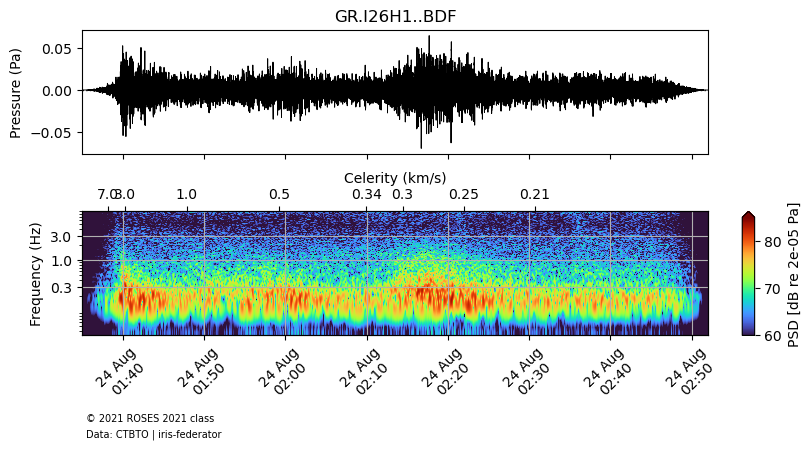

In [25]:
#############################################
# Ploting parameters

amp_min = -1.0
amp_max =  1.0

dB_min =  60.0
dB_max =  85.0

pt0 = t0.datetime
pt1 = t1.datetime

#############################################


n_frames = 2
fig, ax = plt.subplots(n_frames, 1, sharex=True, figsize=(8,4), constrained_layout=True)

formatter = ScalarFormatter()
formatter.set_scientific(False)

########################################################################################
# Waveform
i = 0

ax[i].axhline(y=0, color='black', linewidth=1, linestyle=':')
ax[i].plot(t_mpl, w, 'k', linewidth=0.7)
#ax[i].set_ylim(amp_min,amp_max)
#ax[i].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[i].set(ylabel='Pressure (Pa)')

########################################################################################
## Spectrogram
i += 1
extent = (t_mpl[0], t_mpl[-1], f_min, f_max)
im = ax[i].imshow(Pxx_dB, origin='lower', extent=extent, cmap='turbo',
             vmin=dB_min, vmax=dB_max, interpolation='bilinear')
ax[i].set_yscale('log')
ax[i].set(ylabel='Frequency (Hz)')
ax[i].axis('tight')
ax[i].set_aspect('auto')
ax[i].set_ylim([f_min, f_max])
ax[i].grid()
ax[i].yaxis.set_major_formatter(formatter)
ax[i].yaxis.set_major_locator(FixedLocator([0.3, 1.0, 3.0]))
# Add colorbar
cbar_label = 'PSD [dB re {} Pa]'.format(P_ref)
plt.colorbar(im, ax=ax[i], label=cbar_label, extend='max')

# Plot celerity axis
ax_celerity = ax[i].twiny()
ax_celerity.set_xlim(t_mpl[0], t_mpl[-1])
ax_celerity.set_xticks(celerity_t)
ax_celerity.set_xticklabels(celerities)
ax_celerity.set_xlabel('Celerity (km/s)')

########################################################################################
########################################################################################
## Finalizing plot
ax[i].set_xlim([pt0, pt1])

## Datetime formatting 

# Choose your xtick format string
date_fmt = '%d %b\n%H:%M'

# Use a DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)
ax[n_frames-1].xaxis.set_major_formatter(date_formatter)
ax[n_frames-1].tick_params(axis='x', rotation=45)

## Title plot
station_id = '{network}.{station}.{location}.{channel}'.format(
    network=tr.stats.network,
    station=tr.stats.station,
    location=tr.stats.location,
    channel=tr.stats.channel
    )
title_str = '%s' % ( station_id)
ax[0].set_title(title_str)

## Credits
author = '\xa9 2021 ROSES 2021 class'
fdsn_center = waveform_source_remote['fdsn']
data_source = f'Data: CTBTO | {fdsn_center}'

fig.text(.1, -0.02-0.02, author, ha='left', size=7)
fig.text(.1, -0.04-0.04, data_source, ha='left', size=7)

plt.show()
fid = f'{station_id}.{pt0:%Y%m%d-%H%M}.spectrogram.pdf'
fig.savefig(fid, dpi=300, facecolor='white', bbox_inches='tight')

In [26]:
f_min = 0.3
f_max = 3.0

st.filter('bandpass', freqmin=f_min, freqmax=f_max, corners=4, zerophase=True)

tr = st[0]
w  = tr.data
Fs = tr.stats.sampling_rate
t_unix = tr.times('timestamp')
t_mpl = tr.times('matplotlib')

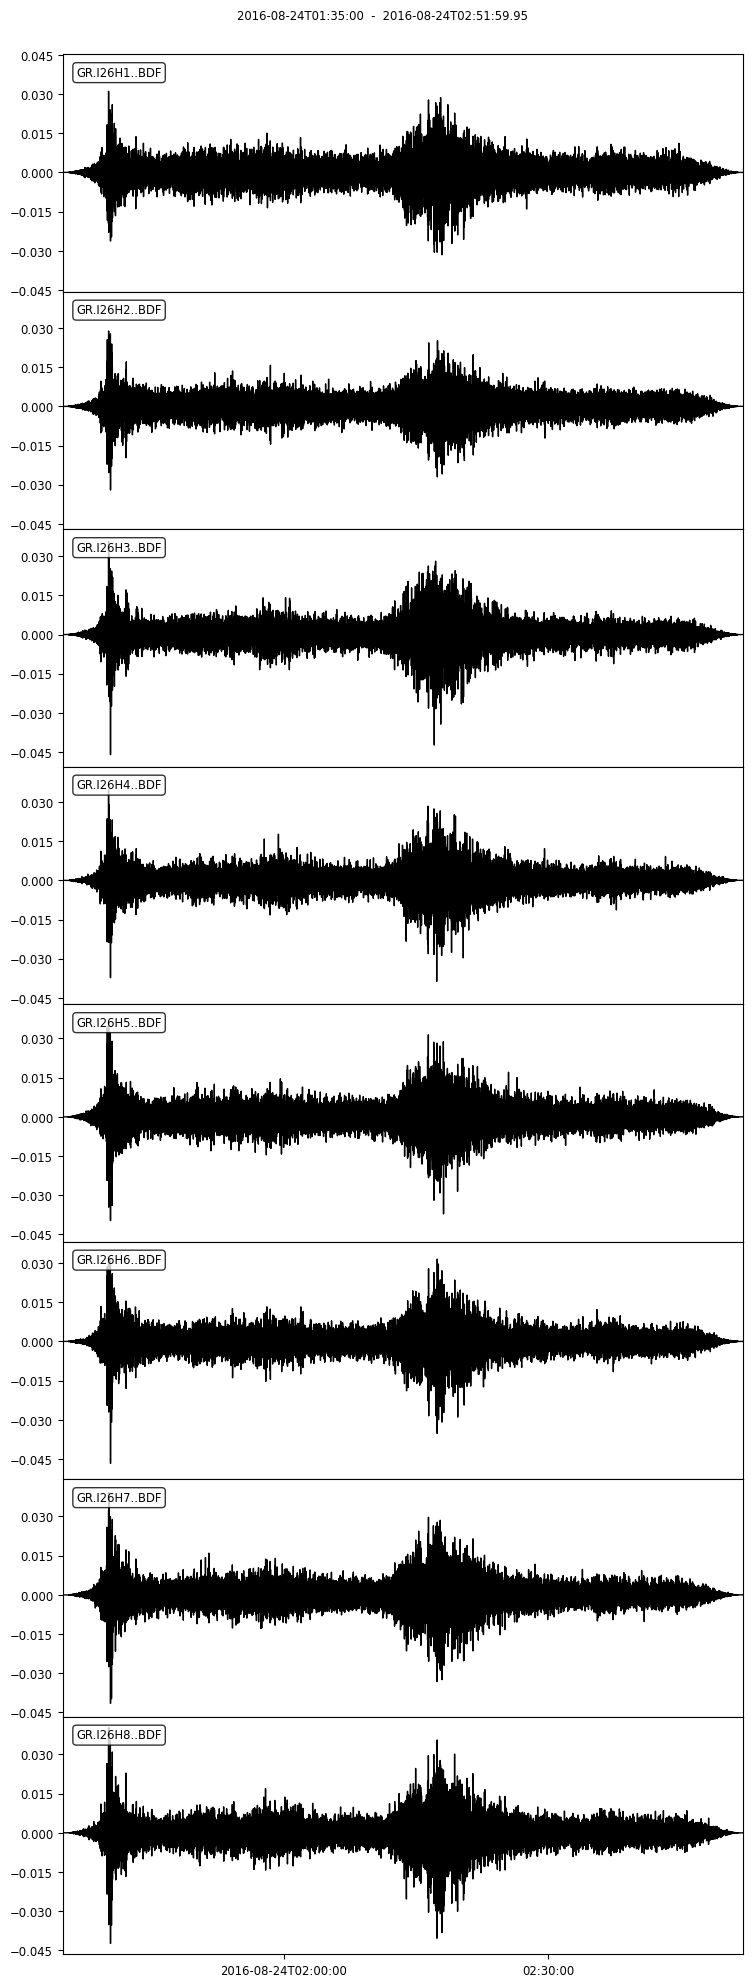

In [27]:
fig = st.plot()

## Array processing

- A good & practical introduction to this topic can be found in the ROSES 2020 module that was taught by <a href='https://github.com/fdannemanndugick/roses2020/blob/master/unit05/array_processing.pdf'>Prof. Stephen Arrowsmith</a> at SMU, Dallas, TX.
<br/>

- We will work here with the array analysis modules that are implemented in ObsPy. These modules are examples of basic good-ole' FK array processing routines that have been the workhorse algorithms for many studies.
<br/>

- Similar routines can be found <a href='https://github.com/jdassink/beamforming'>My GitHub page</a> (FORTRAN). I have optimized them a little more so large volumes of data can be processed quicker. References are included too. Even further optimized Python-FORTRAN versions of these modules have been developed by the seismo-acoustics team @ Delft University of Technology and KNMI and will be published in the future.
<br/>

- A study on CLEAN beamforming for the enhanced detection of multiple infrasonic sources was published by <a href='https://doi.org/10.1093/gji/ggaa010'>Olivier den Ouden et al.</a> in 2020.

### Array response

In [28]:
from obspy.signal.array_analysis import array_transff_freqslowness, get_geometry

To study the spectral properties of beamform techniques, it is instructive to evaluate the array response, which is defined as the f/k spectrum $P(f,\vec{k})$ for a monochromatic wave with unit amplitude or $G(f_{0},\vec{k}_{0}) = e^{i \vec{k}_0 \cdot \vec{r}}$, for which $k_0 = \frac{2 \pi f_0}{c}$. 

The normalized array response for the Bartlett beamformer is defined as:

$R(f_{0}, \vec{k} ;\vec{k}_{0}) = \frac{1}{N}\sum_{n=1}^{N} e^{i (\vec{k}-\vec{k}_0) \cdot \vec{r}_n}$

The array response function may consist of several maxima. The absolute maximum is found at $\vec{k} = \vec{k}_0$ and corresponds to the main lobe. Several side lobes may appear that are a consequence of the spatial sampling of the wavefield with a discrete number of array elements.

In the case of a broadband response, the wavenumber is typically expressed in terms of slowness $\vec{s} = \vec{k} / 2\pi f$.


$R(\vec{s}; \vec{s}_{0}) = \frac{1}{N} \sum_{n=1}^{N} e^{i (\vec{s}-\vec{s}_0) \cdot \vec{r}_n} = \int \frac{1}{N}\sum_{n=1}^{N} e^{i (\vec{k}-\vec{k}_0) \cdot \vec{r}_n} \mathrm{d}f$

#### Adding station geometry to Stream and prepare Numpy array for array response evalation

In [29]:
coords = np.zeros((len(st), 3))
i = 0

for ms in st:
    (net, sta, loc, chan) = ms.id.split('.')
    invs = inv.select(network=net, station=sta, location=loc, channel=chan)
    ms.stats.coordinates = AttribDict({'latitude': invs[0][0][0].latitude,
                                       'longitude': invs[0][0][0].longitude,
                                       'elevation': invs[0][0][0].elevation})
    coords[i,0] = invs[0][0][0].latitude
    coords[i,1] = invs[0][0][0].longitude
    coords[i,2] = invs[0][0][0].elevation
    i += 1

In [30]:
# Slowness maximum (in s/km!)
slim = 1e3 / 250.0

# Slowness steps
sstep = slim/50

# Defines the frequency range over which the response is evaluated. A wider range takes longer to compute.
_f_min = f_min
_f_max = f_max
fstep = _f_min

print(f'Computing Bartlett array response between [{_f_min:.2f} : {fstep:.2f} : {_f_max:.2f}] Hz ..')
R = array_transff_freqslowness(coords, slim, sstep, _f_min, _f_max, fstep, coordsys='lonlat')

sx = np.arange(-slim, slim+sstep, sstep)
sy = sx
Sx, Sy = np.meshgrid(sx, sy)

Computing Bartlett array response between [0.30 : 0.30 : 3.00] Hz ..


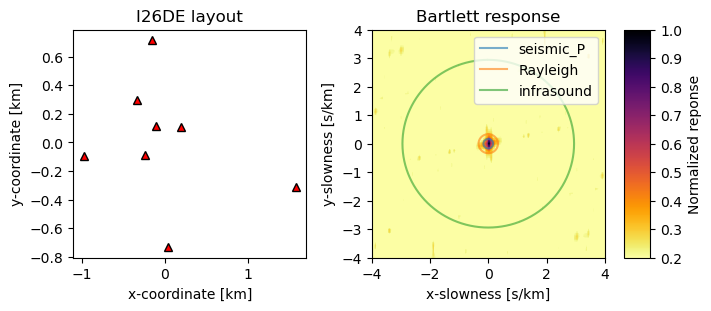

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(7,3), constrained_layout=True)

# Array layout
i = 0
geo = get_geometry(st, coordsys='lonlat', return_center=False, verbose=False)
ax[i].plot(geo[:,0], geo[:,1], '^', color='red', markeredgecolor='black')
ax[i].set_xlabel('x-coordinate [km]')
ax[i].set_ylabel('y-coordinate [km]')
ax[i].set_title(f'{array} layout')

# Response function
i += 1
extent=[-slim, slim, -slim, slim]
im = ax[i].imshow(R, extent=extent, origin='lower',
                  vmin=0.2, vmax=1.0, cmap='inferno_r',
                  aspect='auto')
ax[i].set_xlabel('x-slowness [s/km]')
ax[i].set_ylabel('y-slowness [s/km]')

# Plot slownesses circles for diverse wave classes
angles = np.deg2rad(np.arange(0., 360, 1.))
slowness = dict(seismic_P=6.0, Rayleigh=3.0, infrasound=0.34)
for (key, radius) in slowness.items():
    x_circle = np.sin(angles)/radius
    y_circle = np.cos(angles)/radius
    ax[i].plot(x_circle, y_circle, linestyle='solid', label=key, alpha=0.6)
ax[i].legend()
ax[i].set_title('Bartlett response')
    
plt.colorbar(im, ax=ax[i], label='Normalized reponse')

plt.show()

fid = f'{network}.{array}.{pt0:%Y%m%d-%H%M}.array_response.pdf'
fig.savefig(fid, dpi=300, facecolor='white', bbox_inches='tight')

### Beamforming

The actual processing starts now. We will define a few parameters to configure the beamformer. 
There are many parameters that you can tweak, but you mostly want to change:

- Window length `win_len` (now set to 20 seconds). You want to set the length such that the frequency of interest fits. So larger windows for lower frequencies. And vice versa.
<br/>

- Overlap parameter `win_frac` (now to set to 0.5 for 50% overlap). Choose 0.25 for 75%, 0.1 for 90% overlap, etc. Basically the smaller the parameter, the more overlap and the longer the computation time. 
<br/>

- Slowness grid: you can modify the parameters that define the grid. Parameter `sstep` defines the density of the grid. The smaller the steps, the longer the computation time. In <a href='https://github.com/jdassink/beamforming'>my own code</a> I prefer to define the slowness grid based on the parameters of interest: the back azimuth and the apparent velocity. Therefore I obtain a cylindrical slowness grid. 

In [32]:
stime = st[0].stats.starttime
etime = st[0].stats.endtime
sstep = slim/25

kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, Slow Step
    sll_x=-slim, slm_x=slim, sll_y=-slim, slm_y=slim, sl_s=sstep,
    # sliding window properties
    win_len=20.0, win_frac=0.5,
    # frequency properties
    frqlow=f_min, frqhigh=f_max, prewhiten=0,
    # restrict output
    semb_thres=-1e9, vel_thres=-1e9, timestamp='julsec',
    # time bounds
    stime=stime, etime=etime
)
out = array_processing(st, **kwargs)

The output of the array processing can now be identified and reworked a little for later plotting.

- ObsPy's routines output time, semblance (they call it 'relative power'), FK power (they call it 'absolute power') and the back azimuth (in degrees) and slowness (in s/km).
<br/>

- FK power is basically the sum of energy on the time-aligned traces.
<br/>

- Semblance (see <a href='https://github.com/fdannemanndugick/roses2020/blob/master/unit05/array_processing.pdf'>Prof. Arrowsmith's notes</a>) is the beamformed signal normalized by the ambient power from all other directions-of-arrival.
<br/>

- I compute the Fisher or $F$-statistic (or $F$-ratio) from the Semblance $S$ as $F = (N-1) \frac{S}{1-S}$. The Fisher statistic is a useful parameter for detection as we will see later. 
<br/>

- Also, the Fisher statistic has desirable statistical properties: under the assumption of stationary white Gaussian noise, the Fisher ratio is unity. Basically any deviation means that there is signal. From the Fisher statistic, you can compute the probability of false alarm given a confidence value. For more background, see the <a href='https://repository.tudelft.nl/islandora/object/uuid%3A4de38d6f-8f68-4706-bf34-4003d3dff0ce'>PhD thesis</a> by Prof. Läslo Evers.

In [33]:
n_instr = len(st)

array_proc = dict()
array_proc['time'] = mdates.epoch2num(out[:,0])
array_proc['semblance'] = out[:, 1]
array_proc['fk_power'] = out[:, 2]
# Conversion of semblance to Fisher.
array_proc['fisher'] = (n_instr-1)* array_proc['semblance'] / (1-array_proc['semblance'])

array_proc['bazi'] = out[:, 3] % 360
array_proc['app_vel'] = 1e3 / out[:,4]

### Plot beamform analysis results

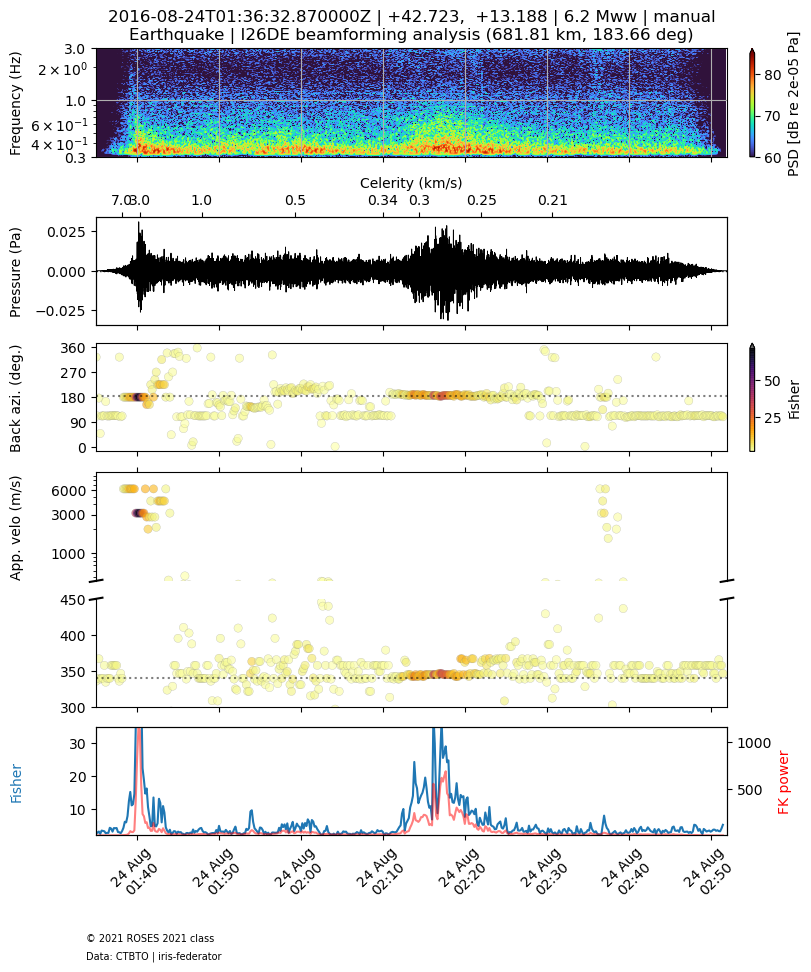

In [34]:
#############################################
# Ploting parameters

amp_min = -1.0
amp_max =  1.0

dB_min =  60.0
dB_max =  85.0

pt0 = t0.datetime
pt1 = t1.datetime

############################################

# Plot
marker_config = dict(alpha=0.6, edgecolors='gray', linewidth=0.2, cmap='inferno_r')

n_frames = 6
fig, ax = plt.subplots(n_frames, 1, sharex=True, figsize=(8,9), constrained_layout=True)

formatter = ScalarFormatter()
formatter.set_scientific(False)

det_stat = {'Fisher': array_proc['fisher']}
det_values = list(det_stat.values())[0]

########################################################################################
# Spectrogram
i = 0
extent = (t_mpl[0], t_mpl[-1], f_min, f_max)
im = ax[i].imshow(Pxx_dB, origin='lower', extent=extent, cmap='turbo',
             vmin=dB_min, vmax=dB_max, interpolation='bilinear')
ax[i].set_yscale('log')
ax[i].set(ylabel='Frequency (Hz)')
ax[i].axis('tight')
ax[i].set_aspect('auto')
ax[i].set_ylim([f_min, f_max])
ax[i].grid()
ax[i].yaxis.set_major_formatter(formatter)
ax[i].yaxis.set_major_locator(FixedLocator([0.3, 1.0, 3.0]))

# Add colorbar
cbar_label = 'PSD [dB re {} Pa]'.format(P_ref)
plt.colorbar(im, ax=ax[i], label=cbar_label, extend='max')

########################################################################################
# Waveform
i += 1
ax[i].axhline(y=0, color='black', linewidth=1, linestyle=':')
ax[i].plot(t_mpl, w, 'k', linewidth=0.7)
#ax[i].set_ylim(amp_min,amp_max)
#ax[i].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[i].set(ylabel='Pressure (Pa)')
# Plot celerity axis
ax_celerity = ax[i].twiny()
ax_celerity.set_xlim(t_mpl[0], t_mpl[-1])
ax_celerity.set_xticks(celerity_t)
ax_celerity.set_xticklabels(celerities)
ax_celerity.set_xlabel('Celerity (km/s)')

########################################################################################
# Back azimuth
i += 1
ax[i].axhline(y=bazi, linestyle='dotted', alpha=0.5, color='black')
im = ax[i].scatter(array_proc['time'], array_proc['bazi'], c=det_values, **marker_config)
ax[i].yaxis.set_major_locator(MultipleLocator(90))
# Add colorbar
cbar_label = list(det_stat.keys())[0]
plt.colorbar(im, ax=ax[i], label=cbar_label, extend='max')
ax[i].set(ylabel='Back azi. (deg.)')

########################################################################################
# Apparent (trace) velocity
i += 1
im = ax[i].scatter(array_proc['time'], array_proc['app_vel'], c=det_values, **marker_config)

# Make upper part apparent velocity axis (logarithmic scaling)
ax[i].set_ylim([450, 10e3])
ax[i].set(ylabel='App. velo (m/s)')
ax[i].set_yscale('log')
ax[i].yaxis.set_major_formatter(formatter)
ax[i].yaxis.set_major_locator(FixedLocator([1000, 3000, 6000]))

# Lower part apparent velocity axis (linear scaling)
ax[i+1].set_ylim([300, 450])
ax[i+1].axhline(y=340.0, linestyle='dotted', alpha=0.5, color='black')
im = ax[i+1].scatter(array_proc['time'], array_proc['app_vel'], c=det_values, **marker_config)

# Do the diagnonal lines

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax[i].transAxes, color='k', clip_on=False)
ax[i].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax[i].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax[i+1].transAxes)  # switch to the bottom axes
ax[i+1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax[i+1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# hide the spines between the two axis
ax[i].spines['bottom'].set_visible(False)
ax[i+1].spines['top'].set_visible(False)
ax[i].xaxis.tick_top()
ax[i].tick_params(labeltop=False)  # don't put tick labels at the top
ax[i+1].xaxis.tick_bottom()

########################################################################################
# Fisher and FK power
i += 2
ax[i].plot(array_proc['time'], array_proc['fisher'], 'C0', linewidth=1.5)
ax[i].set_ylim([array_proc['fisher'].min(), array_proc['fisher'].max()])
ax[i].set_ylim([array_proc['fisher'].min(), 35])
ax[i].set_ylabel('Fisher', color='C0')

axr = ax[i].twinx()
axr.plot(array_proc['time'], array_proc['fk_power'], 'r', alpha=0.5)
axr.set_ylim([array_proc['fk_power'].min(), array_proc['fk_power'].max()])
axr.set_ylabel('FK power', color='red')

########################################################################################
########################################################################################
## Finalizing plot

ax[0].set_xlim([pt0, pt1])

## Datetime formatting 
# Choose your xtick format string
date_fmt = '%d %b\n%H:%M'

# Use a DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)
ax[n_frames-1].xaxis.set_major_formatter(date_formatter)
ax[n_frames-1].tick_params(axis='x', rotation=45)
# Sets the tick labels diagonal so they fit easier.
#fig.autofmt_xdate(rotation=70)

event_type = event.event_type.capitalize()
event_description = event.event_descriptions[0].text
title_str = (f'{event.short_str()}\n{event_type} | '
             f'{array} beamforming analysis ({dist_km:.2f} km, {bazi:.2f} deg)')
ax[0].set_title(title_str)

fig.align_ylabels(ax)

## Credits
author = '\xa9 2021 ROSES 2021 class'
fdsn_center = waveform_source_remote['fdsn']
data_source = f'Data: CTBTO | {fdsn_center}'

fig.text(.1, -0.02-0.02, author, ha='left', size=7)
fig.text(.1, -0.04-0.02, data_source, ha='left', size=7)

plt.show()

fid = f'{network}.{array}.{pt0:%Y%m%d-%H%M}.beamforming.pdf'
fig.savefig(fid, dpi=300, facecolor='white', bbox_inches='tight')

### FK analysis to supplement array-analysis-as-function-of-time

The upper plot is a typical array processing plot. It shows slowness parameters (converted to back azimuth and apparent velocity) that correspond to the most dominant wave arrival, per time-bin.

It can be useful to complement this analysis with FK analysis that shows full slowness grid. Such analyses are helpful in understanding the 'FK response' that has been computed with the dataset and the chosen set of parameters. 

In addition it also helps to understand if any sidelobes with major amplitude levels exist. The existence of such sidelobes occurs due to spatial aliasing. Not identifying these sidelobes as such could lead to misinterpretation.


<a href='https://doi.org/10.1093/gji/ggaa010'>CLEAN beamforming</a> can be used to deconvolve the array response from the FK analysis. This can help to identify multiple sources that could be present in the array waveforms. As that study shows, it is important that the initial FK analysis is not biased. This could for example be case when Bartlett's beam is used. Compared to Capon's beam, Bartlett's beam provides a lower resolution.

Capon's beam is mathematically a little more involved and requires judicious setting of parameters. In this ROSES module, we will not treat Capon.


In [35]:
from array_processing import plotFK

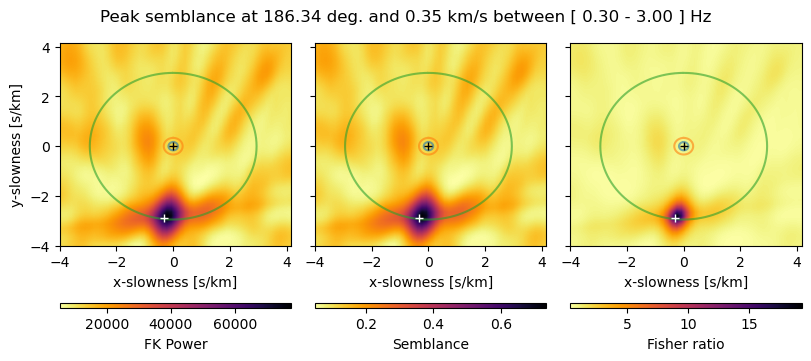

In [36]:
time_start = UTCDateTime('2016-08-24T02:15:00')
time_end = UTCDateTime('2016-08-24T02:20:00')

_f_min = f_min
_f_max = f_max

(fig, ax) = plotFK(st, time_start, time_end, _f_min, _f_max, 
                   # slowness grid: X min, X max, Y min, Y max, Slow Step
                   sll_x=-slim, slm_x=slim, sll_y=-slim, slm_y=slim, sl_s=sstep,
                   normalize=False, beam='bartlett', prewhiten=0,
                   cmap='inferno_r', interpolation='bilinear',
                   sl_circle=True, plot_normalize=False)

fid = f'{network}.{array}.{time_start.datetime:%Y%m%d-%H%M}.FK.pdf'
fig.savefig(fid, dpi=300, facecolor='white', bbox_inches='tight')

Note the reduced sidelobes when the FK spectrum is expressed by the Fisher ratio

# Bonus excercise 1

Carry out the seismo-acoustic analysis for the other M6 earthquakes from the 2016 Central Italy sequence for array GR.I26DE

Investigate the results. Google Earth is a useful tool. Which differences do you see? Can you relate the observations to features on the Earth surface?

In [37]:
# M 6.1 - 2 km NNW of Visso, Italy (26 Oct. 2016)
catalog = client.get_events(eventid='us1000725y')

#catalog.write('event.xml', format='QuakeML')
print(catalog)
event = catalog[0]
origin = event.preferred_origin()

# take these bounds to select from the inventory
event_day_t0 = origin.time.replace(hour=0, minute=0, second=0, microsecond=0)
event_day_t1 = event_day_t0 + 24*3600

1 Event(s) in Catalog:
2016-10-26T19:18:08.430000Z | +42.956,  +13.067 | 6.1 Mww | manual


In [38]:
inv = get_metadata(metadata_source_remote, network=network, station=station,
                   location=location, channel=channel, starttime=event_day_t0, endtime=event_day_t1)

print(inv)
inv.write(fid_inv, 'STATIONXML')

Inventory created at 2021-08-29T10:41:55.419890Z
	Created by: ObsPy 1.2.2
		    https://www.obspy.org
	Sending institution: ObsPy FDSN Routing 1.2.2,SeisComP (BGR)
	Contains:
		Networks (1):
			GR
		Stations (8):
			GR.I26H1 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H2 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H3 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H4 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H5 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H6 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H7 (BGR Station Infrasound Array CTBTO IS26, Germany)
			GR.I26H8 (BGR Station Infrasound Array CTBTO IS26, Germany)
		Channels (8):
			GR.I26H1..BDF, GR.I26H2..BDF, GR.I26H3..BDF, GR.I26H4..BDF, 
			GR.I26H5..BDF, GR.I26H6..BDF, GR.I26H7..BDF, GR.I26H8..BDF


In [39]:
rcv = inv[0][0][0]
(dist_m, azi, bazi) = gps2dist_azimuth(origin.latitude, origin.longitude, rcv.latitude, rcv.longitude)
dist_km = dist_m / 1e3

print(f'Source-receiver distance {dist_km:.2f} km')
print(f'Source-receiver azimuth {azi:.2f} degrees')
print(f'Source-receiver back-azimuth {bazi:.2f} degrees')

Source-receiver distance 656.58 km
Source-receiver azimuth 4.18 degrees
Source-receiver back-azimuth 184.65 degrees


In [40]:
# Get waveform data
t0 = origin.time - 60
t1 = origin.time + dist_km / celerity_min

t0 = t0.replace(second=0, microsecond=0)
t1 = t1.replace(second=0, microsecond=0)
print(t0,t1)
margin = 10
sample_rate = 1.0/inv[0][0][0].sample_rate
st = get_data(waveform_source_remote, inventory=inv, starttime=t0-margin, endtime=t1-sample_rate+margin)
st.trim(t0,t1)
#st.write(fid_mseed, 'mseed')
print(st)
stream2sds(st, path_root=sds_root)

2016-10-26T19:17:00.000000Z 2016-10-26T20:31:00.000000Z
8 Trace(s) in Stream:
GR.I26H1..BDF | 2016-10-26T19:17:00.000000Z - 2016-10-26T20:31:00.000000Z | 20.0 Hz, 88801 samples
GR.I26H2..BDF | 2016-10-26T19:17:00.000000Z - 2016-10-26T20:31:00.000000Z | 20.0 Hz, 88801 samples
GR.I26H3..BDF | 2016-10-26T19:17:00.000000Z - 2016-10-26T20:31:00.000000Z | 20.0 Hz, 88801 samples
GR.I26H4..BDF | 2016-10-26T19:17:00.000000Z - 2016-10-26T20:31:00.000000Z | 20.0 Hz, 88801 samples
GR.I26H5..BDF | 2016-10-26T19:17:00.000000Z - 2016-10-26T20:31:00.000000Z | 20.0 Hz, 88801 samples
GR.I26H6..BDF | 2016-10-26T19:17:00.000000Z - 2016-10-26T20:31:00.000000Z | 20.0 Hz, 88801 samples
GR.I26H7..BDF | 2016-10-26T19:17:00.000000Z - 2016-10-26T20:31:00.000000Z | 20.0 Hz, 88801 samples
GR.I26H8..BDF | 2016-10-26T19:17:00.000000Z - 2016-10-26T20:31:00.000000Z | 20.0 Hz, 88801 samples
Writing mseed file [ data/2016/GR/I26H1/BDF.D/GR.I26H1..BDF.D.2016.300 ] -> OK!
Writing mseed file [ data/2016/GR/I26H2/BDF.D/GR.I

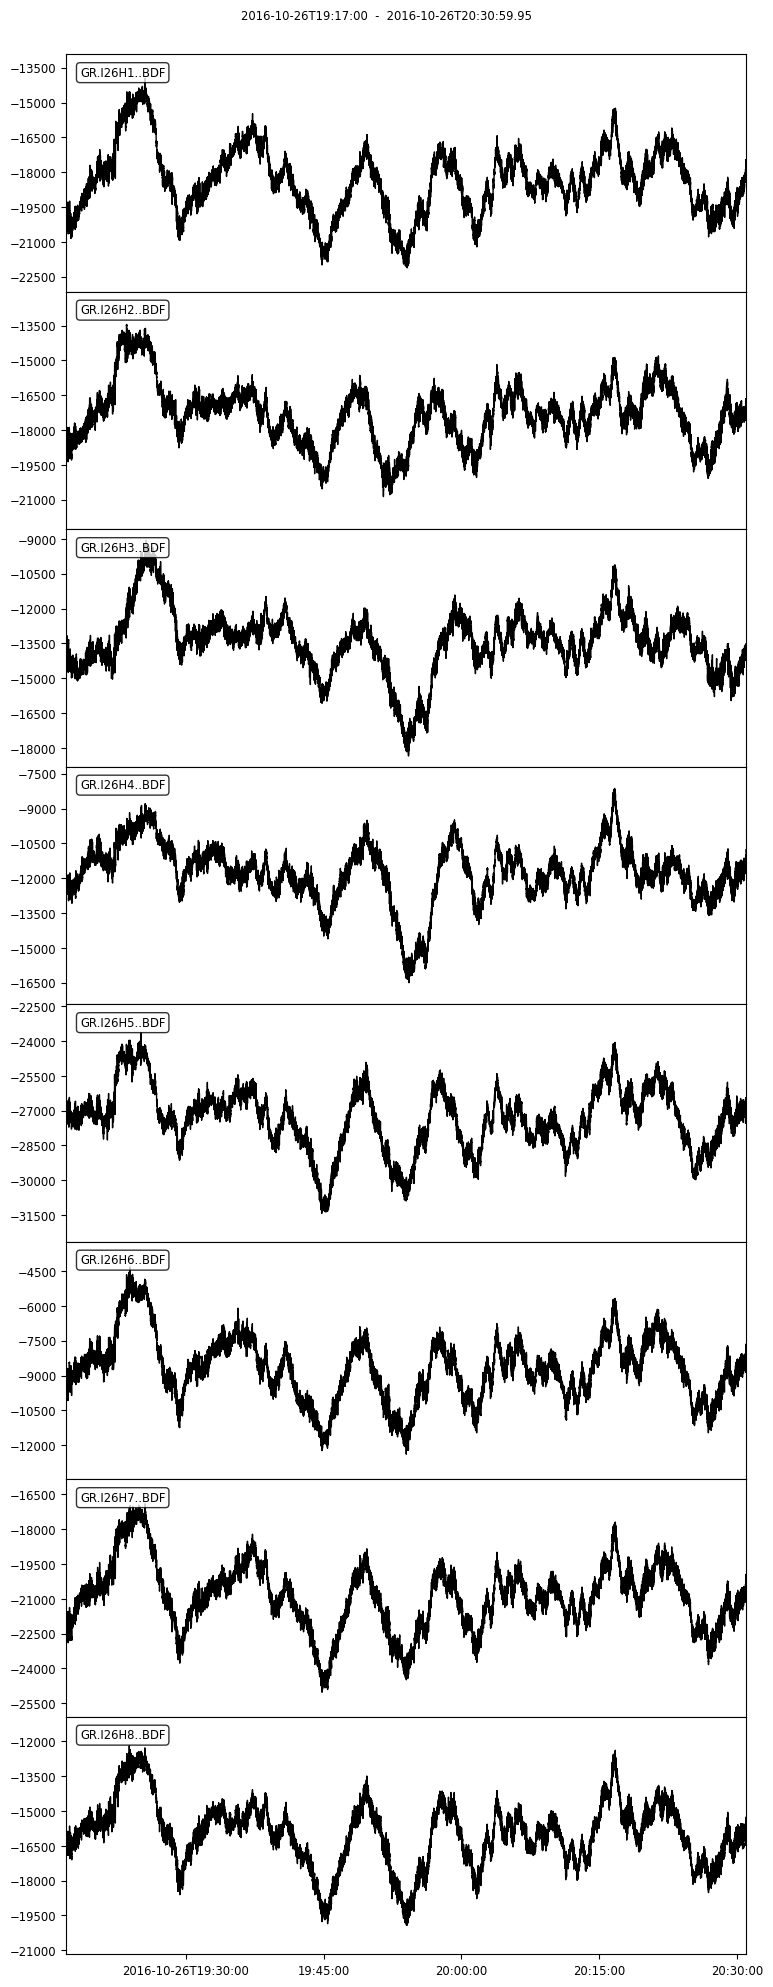

In [41]:
# View waveforms
st = get_data(waveform_source_local, inventory=inv, starttime=t0, endtime=t1)
fig = st.plot();

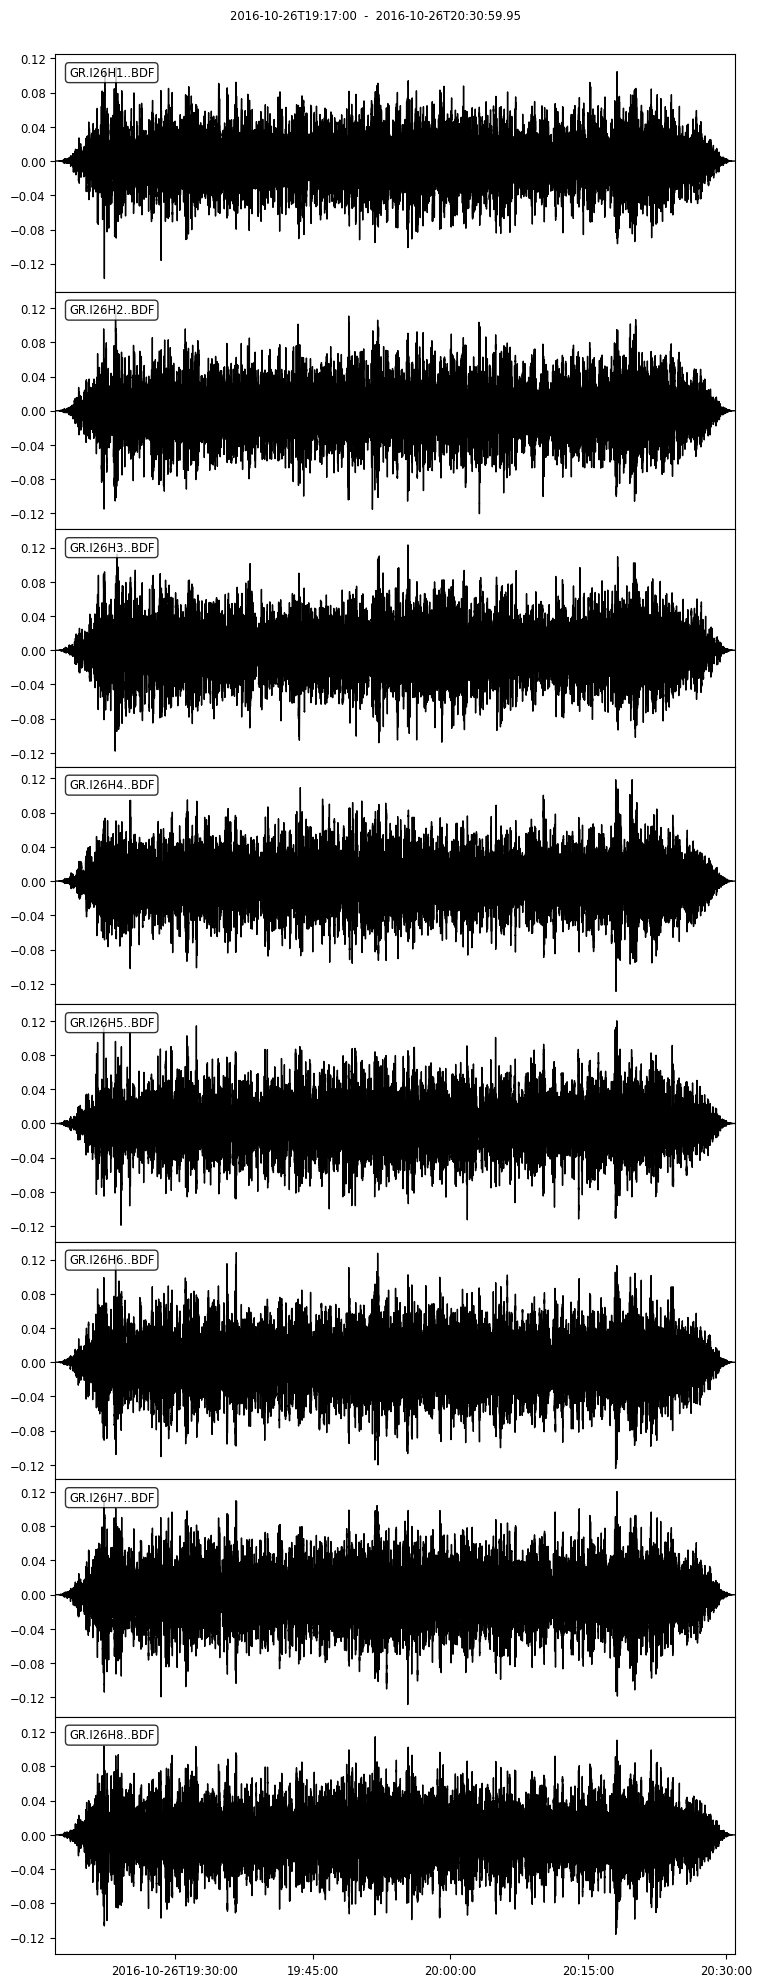

In [42]:
# Remove response
inv = read_inventory(fid_inv)
ref_ele = inv.get_contents()['channels'][0]
resp = inv.get_response(ref_ele, event_day_t0)
f_min = 0.1
f_max = 9.0

pre_filt = [0.9*f_min, f_min, f_max, 1.1*f_max]
st.remove_response(inventory=inv, pre_filt=pre_filt)

st.taper(0.1)
st.trim(t0, t1)

fig = st.plot();

GR.I26H1..BDF | 2016-10-26T19:17:00.000000Z - 2016-10-26T20:30:59.950000Z | 20.0 Hz, 88800 samples


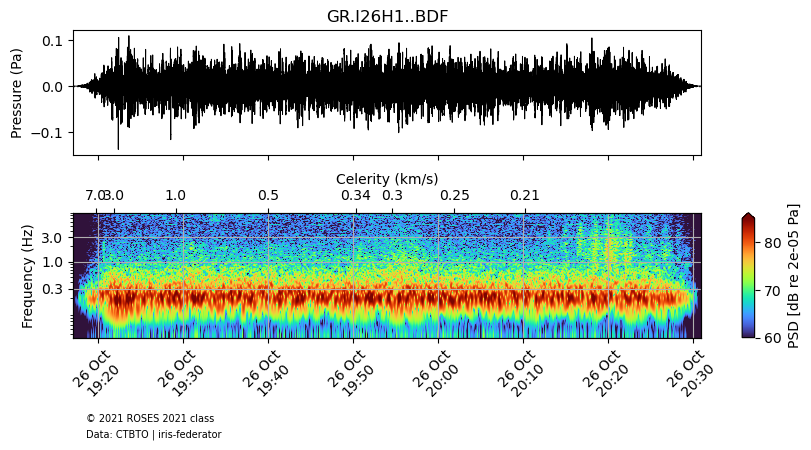

In [43]:
# Spectral analysis
tr = st[0]

print(tr)
w  = tr.data
Fs = tr.stats.sampling_rate
t_unix = tr.times('timestamp')
t_mpl = tr.times('matplotlib')

window_length = 30.0
segment_size = int(window_length*Fs)
oversampling = 4
overlap = 95.0
f_min = 1/window_length

(f, tf, Pxx) = signal.spectrogram(w, Fs,  
                                  window=('hanning'),
                                  nperseg=segment_size, 
                                  nfft=oversampling*segment_size, 
                                  noverlap=(overlap/100)*segment_size,
                                  scaling='density'
                                 )
tf_vec = [timedelta(seconds=t) + tr.stats.starttime.datetime for t in tf ]
tf_mpl = mdates.date2num(tf_vec)

# Select the frequencies of interest
idx = np.where((f>=f_min) & (f<=f_max))
Pxx = Pxx[idx]
f = f[idx]

# Convert to dB re 20e-6 Pa/sqrt(Hz)
P_ref = 20.0e-6
Pxx_dB = 10*np.log10(np.sqrt(Pxx)/np.power(P_ref,2))

celerities = np.array([7.0, 3.0, 1.0, 0.5, 0.34, 0.3, 0.25, 0.21])
celerity_t = np.zeros(celerities.shape)

for i, celerity in enumerate(celerities):
    celerity_t[i] = mdates.epoch2num(origin.time.timestamp + dist_km / celerity)
    
#############################################
# Ploting parameters

amp_min = -1.0
amp_max =  1.0

dB_min =  60.0
dB_max =  85.0

pt0 = t0.datetime
pt1 = t1.datetime

#############################################


n_frames = 2
fig, ax = plt.subplots(n_frames, 1, sharex=True, figsize=(8,4), constrained_layout=True)

formatter = ScalarFormatter()
formatter.set_scientific(False)

########################################################################################
# Waveform
i = 0

ax[i].axhline(y=0, color='black', linewidth=1, linestyle=':')
ax[i].plot(t_mpl, w, 'k', linewidth=0.7)
#ax[i].set_ylim(amp_min,amp_max)
#ax[i].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[i].set(ylabel='Pressure (Pa)')

########################################################################################
## Spectrogram
i += 1
extent = (t_mpl[0], t_mpl[-1], f_min, f_max)
im = ax[i].imshow(Pxx_dB, origin='lower', extent=extent, cmap='turbo',
             vmin=dB_min, vmax=dB_max, interpolation='bilinear')
ax[i].set_yscale('log')
ax[i].set(ylabel='Frequency (Hz)')
ax[i].axis('tight')
ax[i].set_aspect('auto')
ax[i].set_ylim([f_min, f_max])
ax[i].grid()
ax[i].yaxis.set_major_formatter(formatter)
ax[i].yaxis.set_major_locator(FixedLocator([0.3, 1.0, 3.0]))
# Add colorbar
cbar_label = 'PSD [dB re {} Pa]'.format(P_ref)
plt.colorbar(im, ax=ax[i], label=cbar_label, extend='max')

# Plot celerity axis
ax_celerity = ax[i].twiny()
ax_celerity.set_xlim(t_mpl[0], t_mpl[-1])
ax_celerity.set_xticks(celerity_t)
ax_celerity.set_xticklabels(celerities)
ax_celerity.set_xlabel('Celerity (km/s)')

########################################################################################
########################################################################################
## Finalizing plot
ax[i].set_xlim([pt0, pt1])

## Datetime formatting 

# Choose your xtick format string
date_fmt = '%d %b\n%H:%M'

# Use a DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)
ax[n_frames-1].xaxis.set_major_formatter(date_formatter)
ax[n_frames-1].tick_params(axis='x', rotation=45)

## Title plot
station_id = '{network}.{station}.{location}.{channel}'.format(
    network=tr.stats.network,
    station=tr.stats.station,
    location=tr.stats.location,
    channel=tr.stats.channel
    )
title_str = '%s' % ( station_id)
ax[0].set_title(title_str)

## Credits
author = '\xa9 2021 ROSES 2021 class'
fdsn_center = waveform_source_remote['fdsn']
data_source = f'Data: CTBTO | {fdsn_center}'

fig.text(.1, -0.02-0.02, author, ha='left', size=7)
fig.text(.1, -0.04-0.04, data_source, ha='left', size=7)

plt.show()
fid = f'{station_id}.{pt0:%Y%m%d-%H%M}.spectrogram.pdf'
fig.savefig(fid, dpi=300, facecolor='white', bbox_inches='tight')

In [44]:
# Add station geometry
coords = np.zeros((len(st), 3))
i = 0

for ms in st:
    (net, sta, loc, chan) = ms.id.split('.')
    invs = inv.select(network=net, station=sta, location=loc, channel=chan)
    ms.stats.coordinates = AttribDict({'latitude': invs[0][0][0].latitude,
                                       'longitude': invs[0][0][0].longitude,
                                       'elevation': invs[0][0][0].elevation})
    coords[i,0] = invs[0][0][0].latitude
    coords[i,1] = invs[0][0][0].longitude
    coords[i,2] = invs[0][0][0].elevation
    i += 1

In [45]:
# Slowness maximum (in s/km!)
slim = 1e3 / 250.0

# Slowness steps
sstep = slim/50

# Defines the frequency range over which the response is evaluated. A wider range takes longer to compute.
_f_min = f_min
_f_max = f_max
fstep = _f_min

print(f'Computing Bartlett array response between [{_f_min:.2f} : {fstep:.2f} : {_f_max:.2f}] Hz ..')
R = array_transff_freqslowness(coords, slim, sstep, _f_min, _f_max, fstep, coordsys='lonlat')

sx = np.arange(-slim, slim+sstep, sstep)
sy = sx
Sx, Sy = np.meshgrid(sx, sy)

Computing Bartlett array response between [0.03 : 0.03 : 9.00] Hz ..


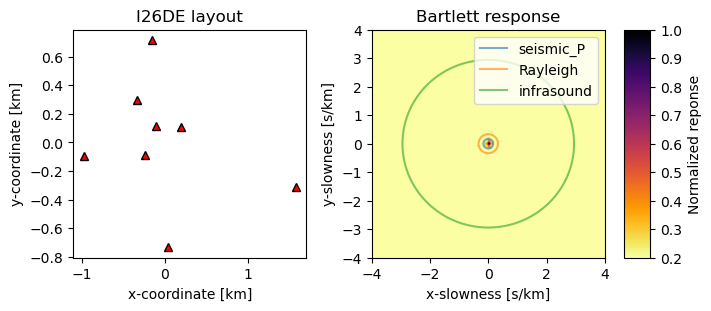

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(7,3), constrained_layout=True)

# Array layout
i = 0
geo = get_geometry(st, coordsys='lonlat', return_center=False, verbose=False)
ax[i].plot(geo[:,0], geo[:,1], '^', color='red', markeredgecolor='black')
ax[i].set_xlabel('x-coordinate [km]')
ax[i].set_ylabel('y-coordinate [km]')
ax[i].set_title(f'{array} layout')

# Response function
i += 1
extent=[-slim, slim, -slim, slim]
im = ax[i].imshow(R, extent=extent, origin='lower',
                  vmin=0.2, vmax=1.0, cmap='inferno_r',
                  aspect='auto')
ax[i].set_xlabel('x-slowness [s/km]')
ax[i].set_ylabel('y-slowness [s/km]')

# Plot slownesses circles for diverse wave classes
angles = np.deg2rad(np.arange(0., 360, 1.))
slowness = dict(seismic_P=6.0, Rayleigh=3.0, infrasound=0.34)
for (key, radius) in slowness.items():
    x_circle = np.sin(angles)/radius
    y_circle = np.cos(angles)/radius
    ax[i].plot(x_circle, y_circle, linestyle='solid', label=key, alpha=0.6)
ax[i].legend()
ax[i].set_title('Bartlett response')
    
plt.colorbar(im, ax=ax[i], label='Normalized reponse')

plt.show()

fid = f'{network}.{array}.{pt0:%Y%m%d-%H%M}.array_response.pdf'
fig.savefig(fid, dpi=300, facecolor='white', bbox_inches='tight')

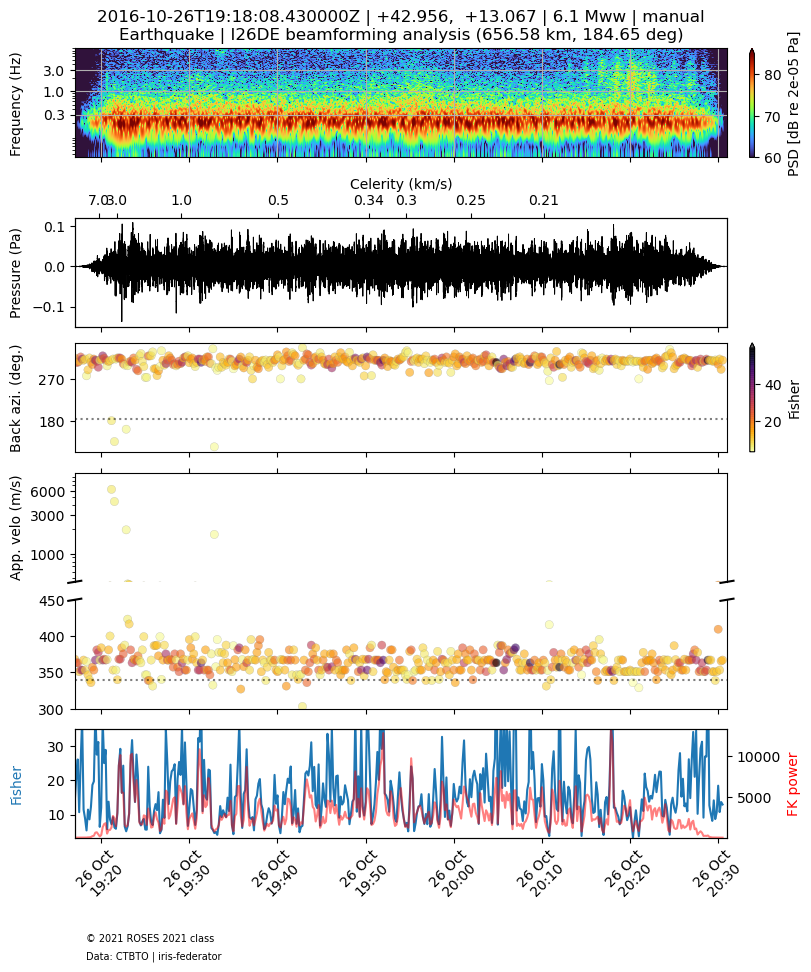

In [47]:
# Beamforming
stime = st[0].stats.starttime
etime = st[0].stats.endtime
sstep = slim/25

kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, Slow Step
    sll_x=-slim, slm_x=slim, sll_y=-slim, slm_y=slim, sl_s=sstep,
    # sliding window properties
    win_len=20.0, win_frac=0.5,
    # frequency properties
    frqlow=f_min, frqhigh=f_max, prewhiten=0,
    # restrict output
    semb_thres=-1e9, vel_thres=-1e9, timestamp='julsec',
    # time bounds
    stime=stime, etime=etime
)
out = array_processing(st, **kwargs)

n_instr = len(st)

array_proc = dict()
array_proc['time'] = mdates.epoch2num(out[:,0])
array_proc['semblance'] = out[:, 1]
array_proc['fk_power'] = out[:, 2]
# Conversion of semblance to Fisher.
array_proc['fisher'] = (n_instr-1)* array_proc['semblance'] / (1-array_proc['semblance'])

array_proc['bazi'] = out[:, 3] % 360
array_proc['app_vel'] = 1e3 / out[:,4]

#############################################
# Ploting parameters

amp_min = -1.0
amp_max =  1.0

dB_min =  60.0
dB_max =  85.0

pt0 = t0.datetime
pt1 = t1.datetime

############################################

# Plot
marker_config = dict(alpha=0.6, edgecolors='gray', linewidth=0.2, cmap='inferno_r')

n_frames = 6
fig, ax = plt.subplots(n_frames, 1, sharex=True, figsize=(8,9), constrained_layout=True)

formatter = ScalarFormatter()
formatter.set_scientific(False)

det_stat = {'Fisher': array_proc['fisher']}
det_values = list(det_stat.values())[0]

########################################################################################
# Spectrogram
i = 0
extent = (t_mpl[0], t_mpl[-1], f_min, f_max)
im = ax[i].imshow(Pxx_dB, origin='lower', extent=extent, cmap='turbo',
             vmin=dB_min, vmax=dB_max, interpolation='bilinear')
ax[i].set_yscale('log')
ax[i].set(ylabel='Frequency (Hz)')
ax[i].axis('tight')
ax[i].set_aspect('auto')
ax[i].set_ylim([f_min, f_max])
ax[i].grid()
ax[i].yaxis.set_major_formatter(formatter)
ax[i].yaxis.set_major_locator(FixedLocator([0.3, 1.0, 3.0]))

# Add colorbar
cbar_label = 'PSD [dB re {} Pa]'.format(P_ref)
plt.colorbar(im, ax=ax[i], label=cbar_label, extend='max')

########################################################################################
# Waveform
i += 1
ax[i].axhline(y=0, color='black', linewidth=1, linestyle=':')
ax[i].plot(t_mpl, w, 'k', linewidth=0.7)
#ax[i].set_ylim(amp_min,amp_max)
#ax[i].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[i].set(ylabel='Pressure (Pa)')
# Plot celerity axis
ax_celerity = ax[i].twiny()
ax_celerity.set_xlim(t_mpl[0], t_mpl[-1])
ax_celerity.set_xticks(celerity_t)
ax_celerity.set_xticklabels(celerities)
ax_celerity.set_xlabel('Celerity (km/s)')

########################################################################################
# Back azimuth
i += 1
ax[i].axhline(y=bazi, linestyle='dotted', alpha=0.5, color='black')
im = ax[i].scatter(array_proc['time'], array_proc['bazi'], c=det_values, **marker_config)
ax[i].yaxis.set_major_locator(MultipleLocator(90))
# Add colorbar
cbar_label = list(det_stat.keys())[0]
plt.colorbar(im, ax=ax[i], label=cbar_label, extend='max')
ax[i].set(ylabel='Back azi. (deg.)')

########################################################################################
# Apparent (trace) velocity
i += 1
im = ax[i].scatter(array_proc['time'], array_proc['app_vel'], c=det_values, **marker_config)

# Make upper part apparent velocity axis (logarithmic scaling)
ax[i].set_ylim([450, 10e3])
ax[i].set(ylabel='App. velo (m/s)')
ax[i].set_yscale('log')
ax[i].yaxis.set_major_formatter(formatter)
ax[i].yaxis.set_major_locator(FixedLocator([1000, 3000, 6000]))

# Lower part apparent velocity axis (linear scaling)
ax[i+1].set_ylim([300, 450])
ax[i+1].axhline(y=340.0, linestyle='dotted', alpha=0.5, color='black')
im = ax[i+1].scatter(array_proc['time'], array_proc['app_vel'], c=det_values, **marker_config)

# Do the diagnonal lines

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax[i].transAxes, color='k', clip_on=False)
ax[i].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax[i].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax[i+1].transAxes)  # switch to the bottom axes
ax[i+1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax[i+1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# hide the spines between the two axis
ax[i].spines['bottom'].set_visible(False)
ax[i+1].spines['top'].set_visible(False)
ax[i].xaxis.tick_top()
ax[i].tick_params(labeltop=False)  # don't put tick labels at the top
ax[i+1].xaxis.tick_bottom()

########################################################################################
# Fisher and FK power
i += 2
ax[i].plot(array_proc['time'], array_proc['fisher'], 'C0', linewidth=1.5)
ax[i].set_ylim([array_proc['fisher'].min(), array_proc['fisher'].max()])
ax[i].set_ylim([array_proc['fisher'].min(), 35])
ax[i].set_ylabel('Fisher', color='C0')

axr = ax[i].twinx()
axr.plot(array_proc['time'], array_proc['fk_power'], 'r', alpha=0.5)
axr.set_ylim([array_proc['fk_power'].min(), array_proc['fk_power'].max()])
axr.set_ylabel('FK power', color='red')

########################################################################################
########################################################################################
## Finalizing plot

ax[0].set_xlim([pt0, pt1])

## Datetime formatting 
# Choose your xtick format string
date_fmt = '%d %b\n%H:%M'

# Use a DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)
ax[n_frames-1].xaxis.set_major_formatter(date_formatter)
ax[n_frames-1].tick_params(axis='x', rotation=45)
# Sets the tick labels diagonal so they fit easier.
#fig.autofmt_xdate(rotation=70)

event_type = event.event_type.capitalize()
event_description = event.event_descriptions[0].text
title_str = (f'{event.short_str()}\n{event_type} | '
             f'{array} beamforming analysis ({dist_km:.2f} km, {bazi:.2f} deg)')
ax[0].set_title(title_str)

fig.align_ylabels(ax)

## Credits
author = '\xa9 2021 ROSES 2021 class'
fdsn_center = waveform_source_remote['fdsn']
data_source = f'Data: CTBTO | {fdsn_center}'

fig.text(.1, -0.02-0.02, author, ha='left', size=7)
fig.text(.1, -0.04-0.02, data_source, ha='left', size=7)

plt.show()

fid = f'{network}.{array}.{pt0:%Y%m%d-%H%M}.beamforming.pdf'
fig.savefig(fid, dpi=300, facecolor='white', bbox_inches='tight')

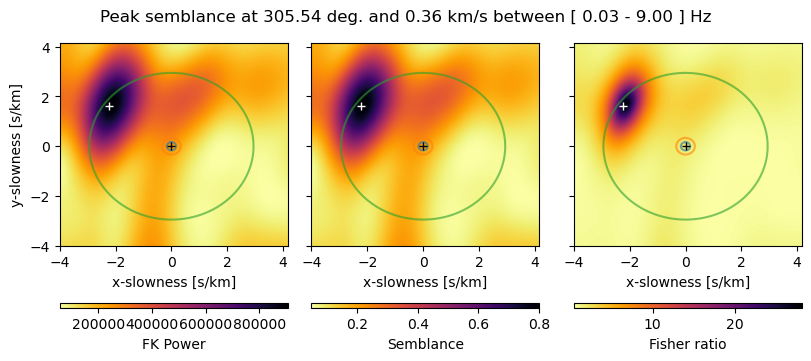

In [49]:
#FK 

# Select a short time window from the trace
time_start = UTCDateTime('2016-10-26T20:05:00')
time_end = UTCDateTime('2016-10-26T20:10:00')

_f_min = f_min
_f_max = f_max

(fig, ax) = plotFK(st, time_start, time_end, _f_min, _f_max, 
                   # slowness grid: X min, X max, Y min, Y max, Slow Step
                   sll_x=-slim, slm_x=slim, sll_y=-slim, slm_y=slim, sl_s=sstep,
                   normalize=False, beam='bartlett', prewhiten=0,
                   cmap='inferno_r', interpolation='bilinear',
                   sl_circle=True, plot_normalize=False)

fid = f'{network}.{array}.{time_start.datetime:%Y%m%d-%H%M}.FK.pdf'
fig.savefig(fid, dpi=300, facecolor='white', bbox_inches='tight')

# Bonus excercise 2

- Perform an analysis for the 29 December 2020 Petrinja, Croatia earthquake. Try to include as many arrays as possible in your analysis. 

- Make use of IRIS' <a href='http://ds.iris.edu/gmap/#channel=*DF&network=*&planet=earth'>map</a> service and a seismic catalog of your preference.

- Consider which frequency bands are appropriate in the analysis. You may have to adjust the processing parameters, depending on the characteristics of your array.<br/>

- Map out where the energy appears to be coming from.

# Bonus excercise 3

Can you find a relation between the intensity of the earthquake and the power measured on the array?

For this excercise it is best to analyse an array that is located near a region with a lot of earthquakes. 
I53US for example.

You can try to query the <a href='https://earthquake.usgs.gov/earthquakes/search/'>USGS database</a> based on the intensity.

# Super bonus

It is possible to back-project the detections to spots on the Earth surface. A recipe for an algorithm can be found in <a href='https://doi.org/10.1002/2017GL076125'>this study</a>.

Can you try to replicate Figure 3 of this study?